In [29]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet'])
nltk.download('averaged_perceptron_tagger')

import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sqlalchemy import create_engine
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- ED Analysis
- Define feature and target variables X and Y

In [11]:
# load data from database
engine = create_engine('sqlite:///disaster.db')
df = pd.read_sql('disaster_messages', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


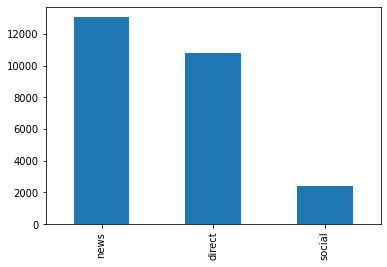

In [12]:
#genre count visualization
df.genre.value_counts().plot(kind='bar')

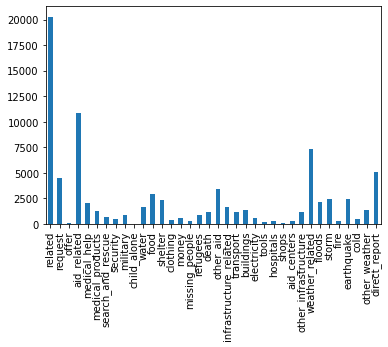

In [13]:
#Distribution of targets/messages categories
df.iloc[:,4:].sum().plot(kind='bar')

In [14]:
#including a new column counting the number of words in a sentence
df['totalwords'] = df['message'].str.split().str.len()

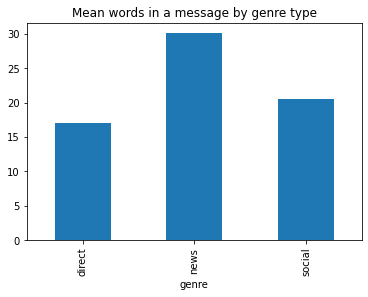

In [15]:
#plot of the mean numbers of words per genre type
df.groupby(['genre'])['totalwords'].mean().plot(kind='bar', title='Mean words in a message by genre type')

Text(0.5, 1.0, 'Number of words per message distribution  - up to 100')

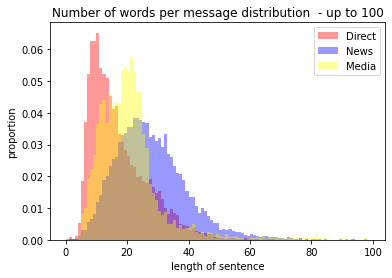

In [16]:
#plot of the number of words per message
plt.hist(df['totalwords'][df['genre'] == 'direct'], bins=range(min(df.totalwords), 100, 1), 
              alpha=0.4, color="red", density=True)

plt.hist(df['totalwords'][df['genre'] == 'news'], bins=range(min(df.totalwords), 100, 1), 
              alpha=0.4, color="blue", density=True)

plt.hist(df['totalwords'][df['genre'] == 'social'], bins=range(min(df.totalwords), 100, 1), 
              alpha=0.4, color="yellow", density=True)

labels = ['Direct',"News", 'Media']
plt.legend(labels)
plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("Number of words per message distribution  - up to 100")

In [17]:
#Drop Child_alone, since it has only 0 values
df.drop(['child_alone'], inplace = True, axis=1)

In [18]:
#checking if we have any value different from 0 or 1
df.iloc[:,4:].describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,totalwords
count,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584,23.855661
std,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114,32.185458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1686.000000


In [19]:
#Once we have values 2 for "related", checking better
df.related.value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

In [20]:
#In the absence of information, I took 2 as an error and decided to consider as the majority class
df['related'] = df['related'].map(lambda x: 1 if x==2 else x)

In [21]:
df.related.value_counts()

1    20094
0     6122
Name: related, dtype: int64

In [22]:
#split into features and target

X = df['message']
Y = df.iloc[:,4:-1]

### 2. Write a tokenization function to process your text data

In [23]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [42]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))  
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7f38e65b2560>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R'

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.64      0.35      0.45      1873
           1       0.82      0.94      0.88      5992

    accuracy                           0.80      7865
   macro avg       0.73      0.64      0.67      7865
weighted avg       0.78      0.80      0.78      7865

request
1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6533
           1       0.78      0.55      0.64      1332

    accuracy                           0.90      7865
   macro avg       0.84      0.76      0.79      7865
weighted avg       0.89      0.90      0.89      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.11      0.03      0.04        36

    accuracy                           0.99      7865
   macro avg       0.55      0.51      0.52      7865
weighted avg       0.99      0.99      0.99   

### 6. Improve your model
Use grid search to find better parameters. 

In [22]:
parameters = {'tfidf__use_idf': (True, False), 
              'clf__estimator__n_estimators': [50, 100],
              'clf__estimator__learning_rate': [1,2]
}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=2, verbose=3)

In [23]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=True, score=0.246, total=  56.0s
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.0s remaining:    0.0s


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=True, score=0.251, total=  56.4s
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=False, score=0.248, total=  47.7s
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=False 
[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, tfidf__use_idf=False, score=0.252, total=  48.4s
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=True 
[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=True, score=0.243, total= 1.8min
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=True 
[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=True, score=0.241, total= 1.8min
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=False 
[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, tfidf__use_idf=False, score=0.250, total= 1.5min
[CV] clf__estimator__

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 20.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [24]:
cv.best_params_

{'clf__estimator__learning_rate': 1,
 'clf__estimator__n_estimators': 50,
 'tfidf__use_idf': False}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [25]:
y_pred = cv.predict(X_test)

In [26]:
for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.64      0.35      0.45      1873
           1       0.82      0.94      0.88      5992

    accuracy                           0.80      7865
   macro avg       0.73      0.64      0.66      7865
weighted avg       0.78      0.80      0.77      7865

request
1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6533
           1       0.79      0.53      0.63      1332

    accuracy                           0.90      7865
   macro avg       0.85      0.75      0.79      7865
weighted avg       0.89      0.90      0.89      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.00      0.00      0.00        36

    accuracy                           0.99      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      0.99      0.99   

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

**Trying Random Forest as a classifier**

In [45]:
#trying a different classifier - Random Forest
pipeline_2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))  
])

In [46]:
pipeline_2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [47]:
y_pred = pipeline_2.predict(X_test)

for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.72      0.26      0.38      1873
           1       0.81      0.97      0.88      5992

    accuracy                           0.80      7865
   macro avg       0.77      0.61      0.63      7865
weighted avg       0.79      0.80      0.76      7865

request
1
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6533
           1       0.90      0.41      0.56      1332

    accuracy                           0.89      7865
   macro avg       0.90      0.70      0.75      7865
weighted avg       0.89      0.89      0.87      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.00      0.00      0.00        36

    accuracy                           1.00      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      1.00      0.99   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7360
           1       0.00      0.00      0.00       505

    accuracy                           0.94      7865
   macro avg       0.47      0.50      0.48      7865
weighted avg       0.88      0.94      0.90      7865

transport
19
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7503
           1       0.78      0.08      0.15       362

    accuracy                           0.96      7865
   macro avg       0.87      0.54      0.56      7865
weighted avg       0.95      0.96      0.94      7865

buildings
20
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7473
           1       0.71      0.03      0.06       392

    accuracy                           0.95      7865
   macro avg       0.83      0.51      0.52      7865
weighted avg       0.94      0.95      0.93     

In [49]:
parameters_2 = {'tfidf__use_idf': (True, False), 
              'clf__estimator__criterion': ['gini', 'entropy'],
              'clf__estimator__class_weight': ['balanced','balanced_subsample']
}

cv_2 = GridSearchCV(pipeline_2, param_grid=parameters_2, cv=2, verbose=3)

In [50]:
cv_2.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=True, score=0.232, total= 2.1min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=True, score=0.225, total= 2.2min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s


[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=False, score=0.223, total= 2.1min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=False 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=gini, tfidf__use_idf=False, score=0.225, total= 2.2min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_idf=True 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_idf=True, score=0.230, total= 2.3min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_idf=True 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_idf=True, score=0.227, total= 2.4min
[CV] clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_idf=False 
[CV]  clf__estimator__class_weight=balanced, clf__estimator__criterion=entropy, tfidf__use_id

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 37.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [51]:
cv_2.best_params_

{'clf__estimator__class_weight': 'balanced',
 'clf__estimator__criterion': 'entropy',
 'tfidf__use_idf': True}

In [52]:
y_pred = cv_2.predict(X_test)

for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.72      0.30      0.43      1873
           1       0.82      0.96      0.88      5992

    accuracy                           0.81      7865
   macro avg       0.77      0.63      0.66      7865
weighted avg       0.79      0.81      0.77      7865

request
1
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6533
           1       0.90      0.44      0.59      1332

    accuracy                           0.90      7865
   macro avg       0.90      0.71      0.76      7865
weighted avg       0.90      0.90      0.88      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.00      0.00      0.00        36

    accuracy                           1.00      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      1.00      0.99   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      6832
           1       0.87      0.01      0.02      1033

    accuracy                           0.87      7865
   macro avg       0.87      0.51      0.48      7865
weighted avg       0.87      0.87      0.81      7865

infrastructure_related
18
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7360
           1       0.00      0.00      0.00       505

    accuracy                           0.94      7865
   macro avg       0.47      0.50      0.48      7865
weighted avg       0.88      0.94      0.90      7865

transport
19
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      7503
           1       0.83      0.01      0.03       362

    accuracy                           0.95      7865
   macro avg       0.89      0.51      0.50      7865
weighted avg       0.95      0.95  

**Trying AdaBoost + new text feature function**

In [25]:
# Build a custom transformer which will extract the starting verb of a sentence
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [40]:
pipeline_3 = Pipeline([
        ('features', FeatureUnion([
            
            ('nlp_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer(use_idf=False))
            ])),
            
            ('sve', StartingVerbExtractor())
        ])),
        
        ('clf', MultiOutputClassifier(AdaBoostClassifier()))
        
        ])

In [ ]:
#Train pipeline 3
pipeline_3.fit(X_train, y_train)

In [31]:
y_pred = pipeline_3.predict(X_test)

for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.64      0.35      0.45      1873
           1       0.82      0.94      0.88      5992

    accuracy                           0.80      7865
   macro avg       0.73      0.64      0.67      7865
weighted avg       0.78      0.80      0.78      7865

request
1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6533
           1       0.78      0.55      0.64      1332

    accuracy                           0.90      7865
   macro avg       0.84      0.76      0.79      7865
weighted avg       0.89      0.90      0.89      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.00      0.00      0.00        36

    accuracy                           1.00      7865
   macro avg       0.50      0.50      0.50      7865
weighted avg       0.99      1.00      0.99   

In [41]:
parameters_3 = {'clf__estimator__n_estimators': [50, 100],
              'clf__estimator__learning_rate': [1,2]
}

cv_3 = GridSearchCV(pipeline_3, param_grid=parameters_3, cv=2, verbose=3)

In [42]:
cv_3.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, score=0.248, total= 1.2min
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=50, score=0.251, total= 1.2min
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, score=0.250, total= 1.9min
[CV] clf__estimator__learning_rate=1, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=1, clf__estimator__n_estimators=100, score=0.250, total= 1.9min
[CV] clf__estimator__learning_rate=2, clf__estimator__n_estimators=50 
[CV]  clf__estimator__learning_rate=2, clf__estimator__n_estimators=50, score=0.000, total= 1.2min
[CV] clf__estimator__learning_rate=2, clf__estimator__n_estimators=50 
[CV]  clf__estimator__learning_rate=2, clf__estimator__n_estimators=50, score=0.000, total= 1.2min
[CV] clf__estimator__learning_rate=2, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=2, clf__estimator__n_estimators=100, score=0.000, total= 1.9min
[CV] clf__estimator__learning_rate=2, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=2, clf__estimator__n_estimators=100, score=0.000, total= 1.9min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.5min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('nlp_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vect',
                                                                                         CountVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.int64'>,
                   

In [43]:
y_pred = cv_3.predict(X_test)

for i, col in enumerate(y_test):
        print(col)
        print(i)
        print(classification_report(y_test[col], y_pred[:,i]))

related
0
              precision    recall  f1-score   support

           0       0.63      0.41      0.50      1873
           1       0.83      0.92      0.88      5992

    accuracy                           0.80      7865
   macro avg       0.73      0.67      0.69      7865
weighted avg       0.79      0.80      0.79      7865

request
1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      6533
           1       0.77      0.55      0.64      1332

    accuracy                           0.90      7865
   macro avg       0.84      0.76      0.79      7865
weighted avg       0.89      0.90      0.89      7865

offer
2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7829
           1       0.08      0.03      0.04        36

    accuracy                           0.99      7865
   macro avg       0.54      0.51      0.52      7865
weighted avg       0.99      0.99      0.99   

###**9. Result - The choosed model was the  AdaBoost + new text feature "SVE" function**

In [ ]:
#Saving the model
with open('model.pkl', 'wb') as f:
    pickle.dump(cv_3, f)